In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models
from scipy.interpolate import bisplrep, bisplev
from rasterio.transform import from_bounds
from rasterio.transform import from_origin
from rasterio.transform import Affine
import rasterio

In [3]:
data=gpd.read_file(r"C:\Users\Janus\Desktop\tesis\datasi.shp")
df=data

In [4]:
# normal score transformation
data = df['K'].values.reshape(-1,1)
nst_transk = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df['NK'] = nst_transk.transform(data) 

In [5]:
gdf=df
# Extraer las coordenadas x, y y los valores z de tu GeoDataFrame
x = gdf.geometry.x
y = gdf.geometry.y
z = gdf['NK']

In [7]:
# Definir la resolución y la extensión del raster de salida
resolucion = 100  # Define la resolución de tu raster
xmin, ymin, xmax, ymax = gdf.total_bounds

# Crear una malla de puntos para el raster utilizando las coordenadas x, y y la resolución
xi = np.arange(xmin, xmax, resolucion)
yi = np.arange(ymin, ymax, resolucion)
xi, yi = np.meshgrid(xi, yi)

# Interpolar los datos utilizando bisplrep
tck = bisplrep(x, y, z, kx=3, ky=3)  # Ajusta el orden del spline en las direcciones x e y

# Evaluar la interpolación en la malla de puntos
zi = bisplev(xi[0,:], yi[:,0], tck)
# Guardar el raster interpolado
transform = from_origin(xmin, ymin, resolucion, resolucion) * Affine.rotation(-90)
with rasterio.open('raster_interpoladon.tif', 'w', driver='GTiff', 
                   height=zi.shape[0], width=zi.shape[1], count=1, 
                   dtype=zi.dtype, crs=gdf.crs, transform=transform
) as dst:
    dst.write(zi, 1)
    dst.nodata = -9999  # Establecer el valor de nodata

print("Raster interpolado guardado exitosamente.")



Raster interpolado guardado exitosamente.


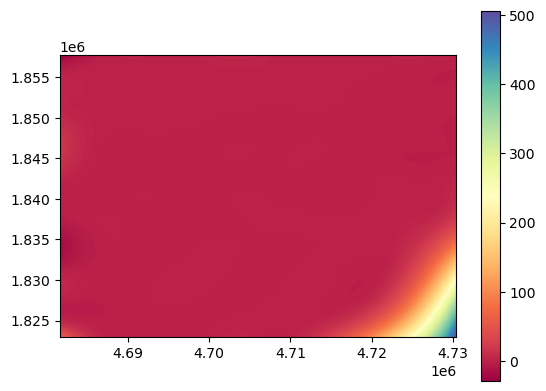

In [8]:
# Hacer el gráfico
cax = plt.imshow(zi, extent=(xmin, xmax, ymin, ymax), origin='lower',cmap='Spectral')

cbar = plt.colorbar(cax)


In [9]:
ahorasik1=nst_transk.inverse_transform(zi.reshape(-1,1))


In [10]:
ahorasik1=ahorasik1.reshape(zi.shape)


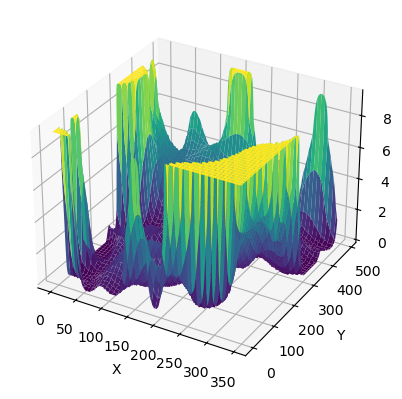

In [11]:
# Crear una cuadrícula de coordenadas x y y basada en el número de columnas y filas del array de líneas
x = np.arange(ahorasik1.shape[1])
y = np.arange(ahorasik1.shape[0])

# Crear una cuadrícula 2D a partir de las coordenadas x y y
X, Y = np.meshgrid(x, y)

# Crear una superficie basada en la cuadrícula y los valores del array de líneas
Z = ahorasik1

# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
ax.plot_surface(X, Y, Z, cmap='viridis')

# Configurar etiquetas de ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Mostrar el gráfico
plt.show()

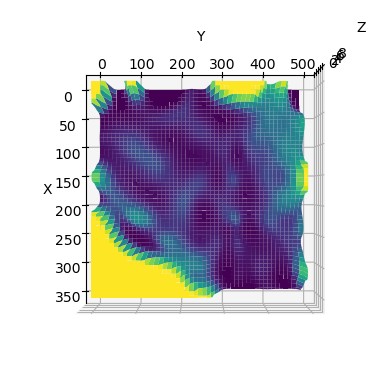

In [13]:
# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Configurar etiquetas de ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Configurar vista desde arriba
ax.view_init(elev=90, azim=0)  # Elevación de 90 grados para ver desde arriba

# Mostrar el gráfico
plt.show()


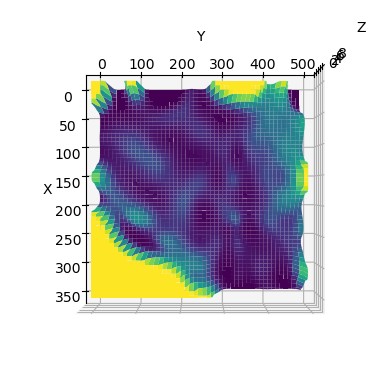

In [14]:

# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Configurar etiquetas de ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Configurar vista desde arriba
ax.view_init(elev=90, azim=0)  # Elevación de 90 grados para ver desde arriba

# Mostrar el gráfico
plt.show()


In [15]:
ruta_raster1 = r"C:\Users\Janus\Desktop\Spline\potasio\ruta_raster_K1def.tif"


In [18]:
import rasterio
from rasterio.features import shapes
with rasterio.open(ruta_raster1) as src1:
    # Lee los datos del raster
    datos_raster1 = src1.read(1)  
    raster_array1 = src1.read(1, masked=True)
    mascara_nodata1 = datos_raster1 == src1.nodata
    transform1 = src1.transform
    shapes1 = list(
        shapes(datos_raster1, mask=None, transform=src1.transform))

In [21]:
import geopandas as gpd
from shapely.geometry import shape

geometrias1 = [shape(geom) for geom, _ in shapes1]
valores_pixeles1 = [valor for _, valor in shapes1]
gdfvtt1 = gpd.GeoDataFrame(geometry=geometrias1, data={'valor_pixel': valores_pixeles1},crs='EPSG:9377')

In [25]:
cortador=gpd.read_file(r"C:\Users\Janus\Desktop\tesis\envolvente.shp")
capa_vectorial_cortadat1 = gpd.overlay(gdfvtt1,cortador, how='intersection')
ruta_cortada1 = 'capa_vectorial_cortada1.shp'
capa_vectorial_cortadat1.to_file(ruta_cortada1)

C:\Users\Janus\AppData\Local\Temp\ipykernel_3908\3028001225.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:9377
Right CRS: PROJCS["MAGNA-SIRGAS_Origen-Nacional",GEOGCS["GCS_ ...

  capa_vectorial_cortadat1 = gpd.overlay(gdfvtt1,cortador, how='intersection')
C:\Users\Janus\AppData\Local\Temp\ipykernel_3908\3028001225.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  capa_vectorial_cortadat1.to_file(ruta_cortada1)


In [27]:
gdf11=df
gdf21 = capa_vectorial_cortadat1
columna_gdf11 = []
columna_gdf21 = []

In [28]:
import geopandas as gpd
# Iterar sobre cada fila del primer GeoDataFrame
for index, row in gdf11.iterrows():
    # Obtener la geometría de la fila actual
    geom = row.geometry
    
    # Buscar si la geometría está presente en el segundo GeoDataFrame
    mask = gdf21.geometry.contains(geom)
    
    if mask.any():
        columna_gdf11.append(row['K'])
        columna_gdf21.append(gdf21[mask]['valor_pixel'].values[0])  # Reemplazar 'nombre_de_la_columna' con el nombre de la columna que deseas obtener de gdf2

# Crear un DataFrame con las listas de resultados
df_resultado1 = pd.DataFrame({'obv': columna_gdf11, 'pre': columna_gdf21})

# Guardar el DataFrame de resultados en un archivo CSV
df_resultado1.to_csv('resultado_t1.csv', index=False)


In [30]:
observados1=df_resultado1['obv']
predichos1=df_resultado1['pre']

In [31]:
from tabulate import tabulate


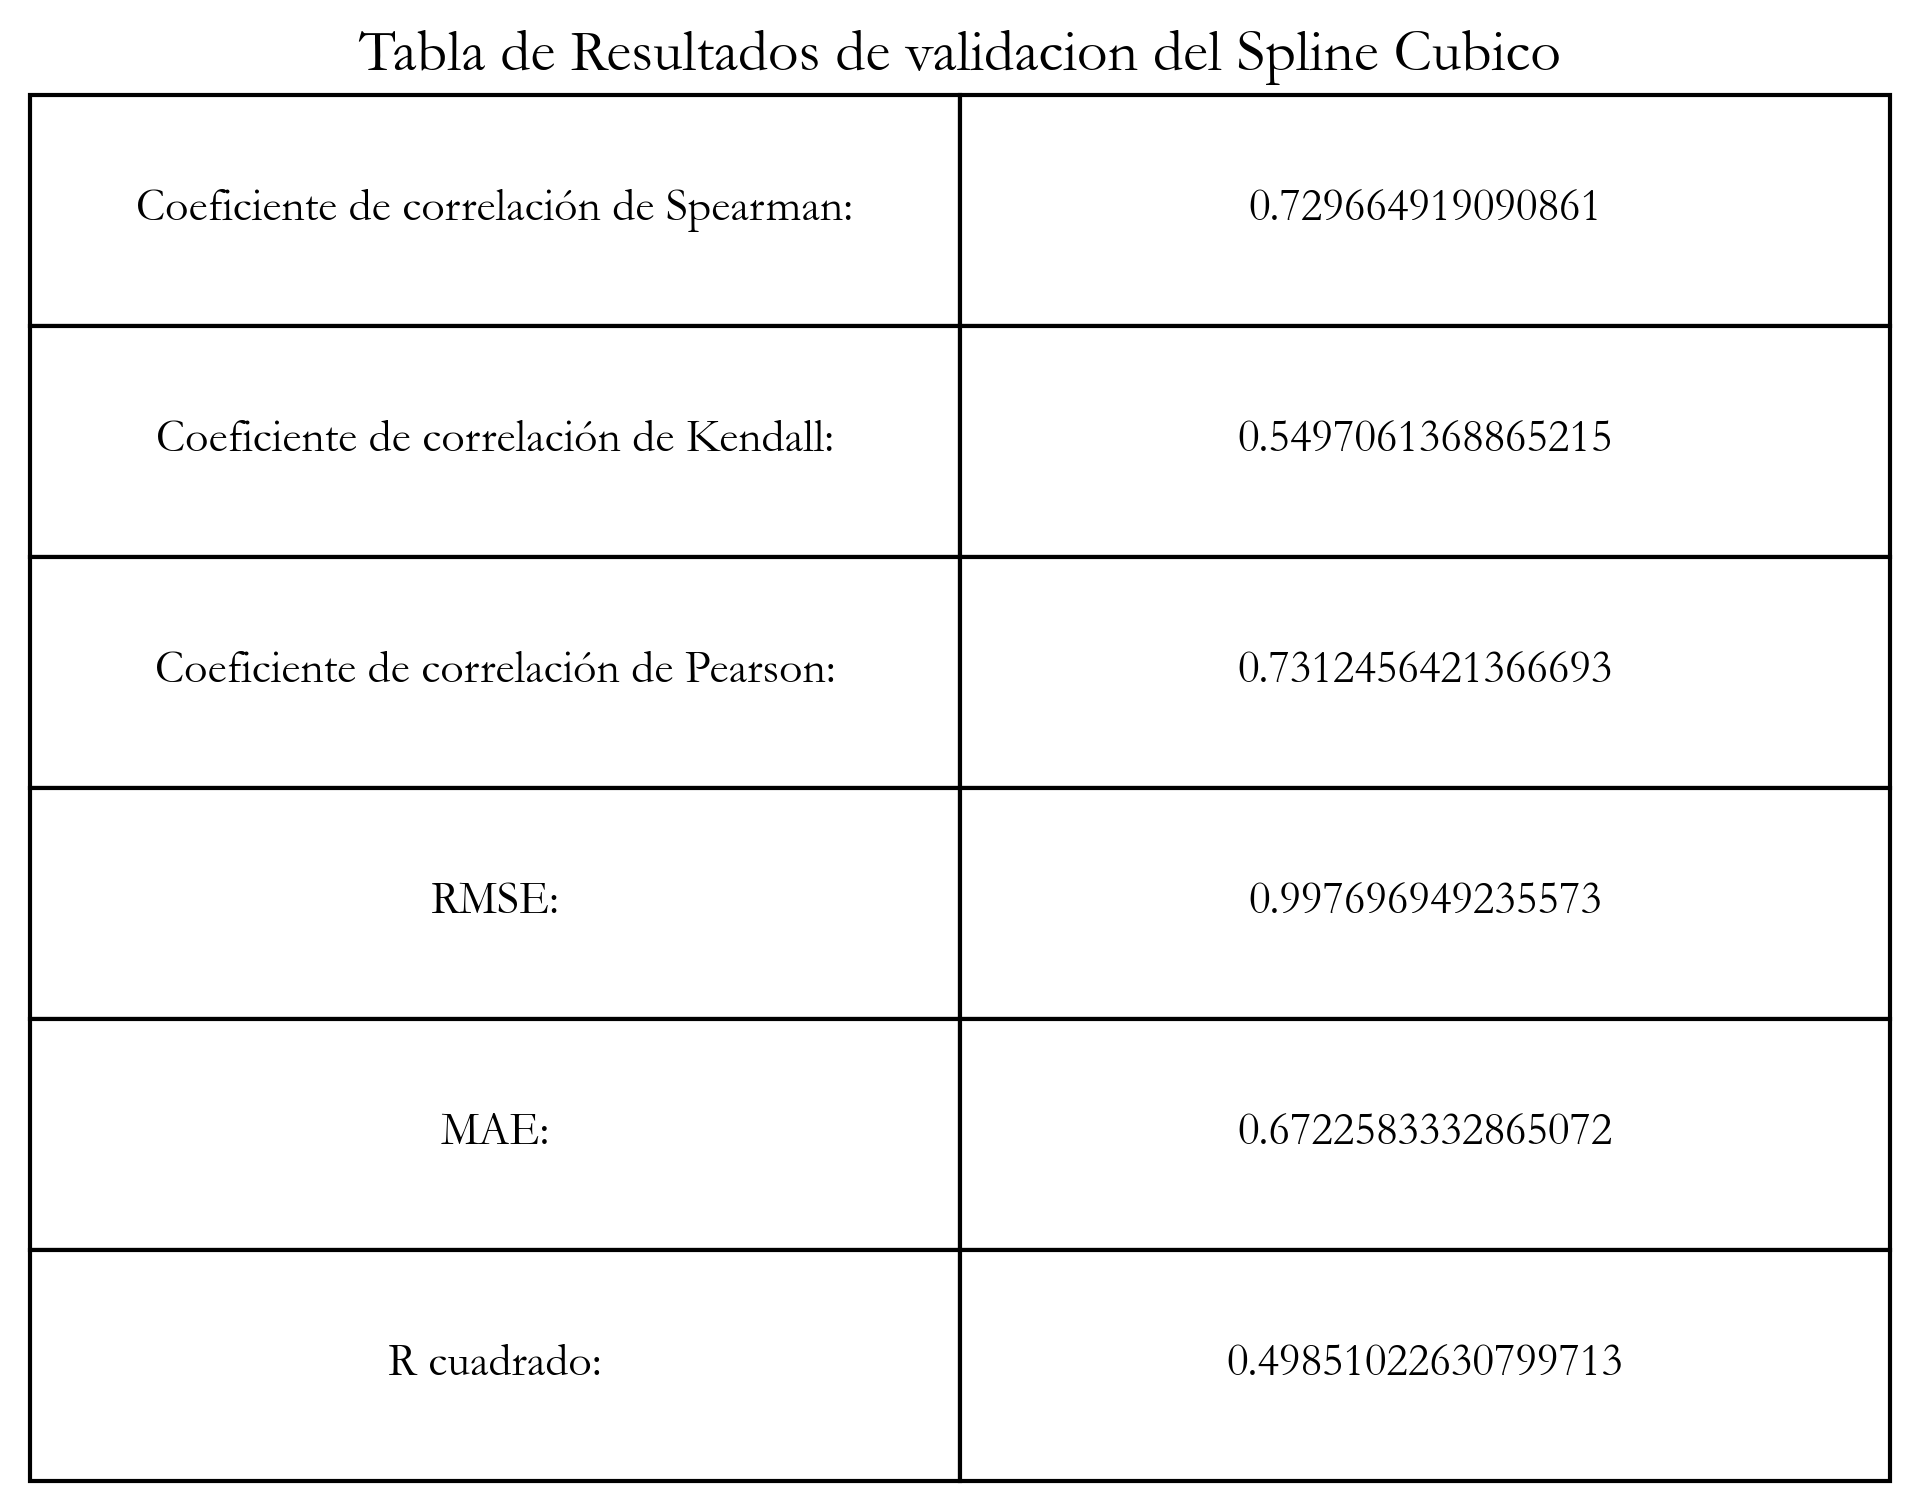

In [34]:
from scipy.stats import spearmanr, kendalltau, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calcula el coeficiente de correlación de Spearman
coeficiente_spearman, _ = spearmanr(observados1, predichos1)

# Calcula el coeficiente de correlación de Kendall
coeficiente_kendall, _ = kendalltau(observados1, predichos1)

# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(observados1, predichos1))

# Calcula el MAE
mae = mean_absolute_error(observados1, predichos1)

# Calcula el R cuadrado
r_cuadrado = r2_score(observados1, predichos1)
coeficiente_pearson, _ = pearsonr(observados1, predichos1)
data = [
    ["Coeficiente de correlación de Spearman:", coeficiente_spearman],
    ["Coeficiente de correlación de Kendall:", coeficiente_kendall],
    ["Coeficiente de correlación de Pearson:", coeficiente_pearson],
    ["RMSE:", rmse],
    ["MAE:", mae],
    ["R cuadrado:", r_cuadrado]
]
tabla = tabulate(data)
with open("tabla.txt", "w") as f:
    f.write(tabla)
plt.figure(figsize=(8, 6),dpi=300)
plt.rcParams.update({'font.size': 12, 'font.family': 'Garamond'})
plt.title('Tabla de Resultados de validacion del Spline Cubico')  # Añadir título
plt.axis('off')  
plt.table(cellText=data, loc='center', bbox=[0, 0, 1, 1], cellLoc='center')
plt.savefig('tabla_sp.png', bbox_inches='tight', pad_inches=0.0)
plt.show()


In [35]:
import seaborn as sns

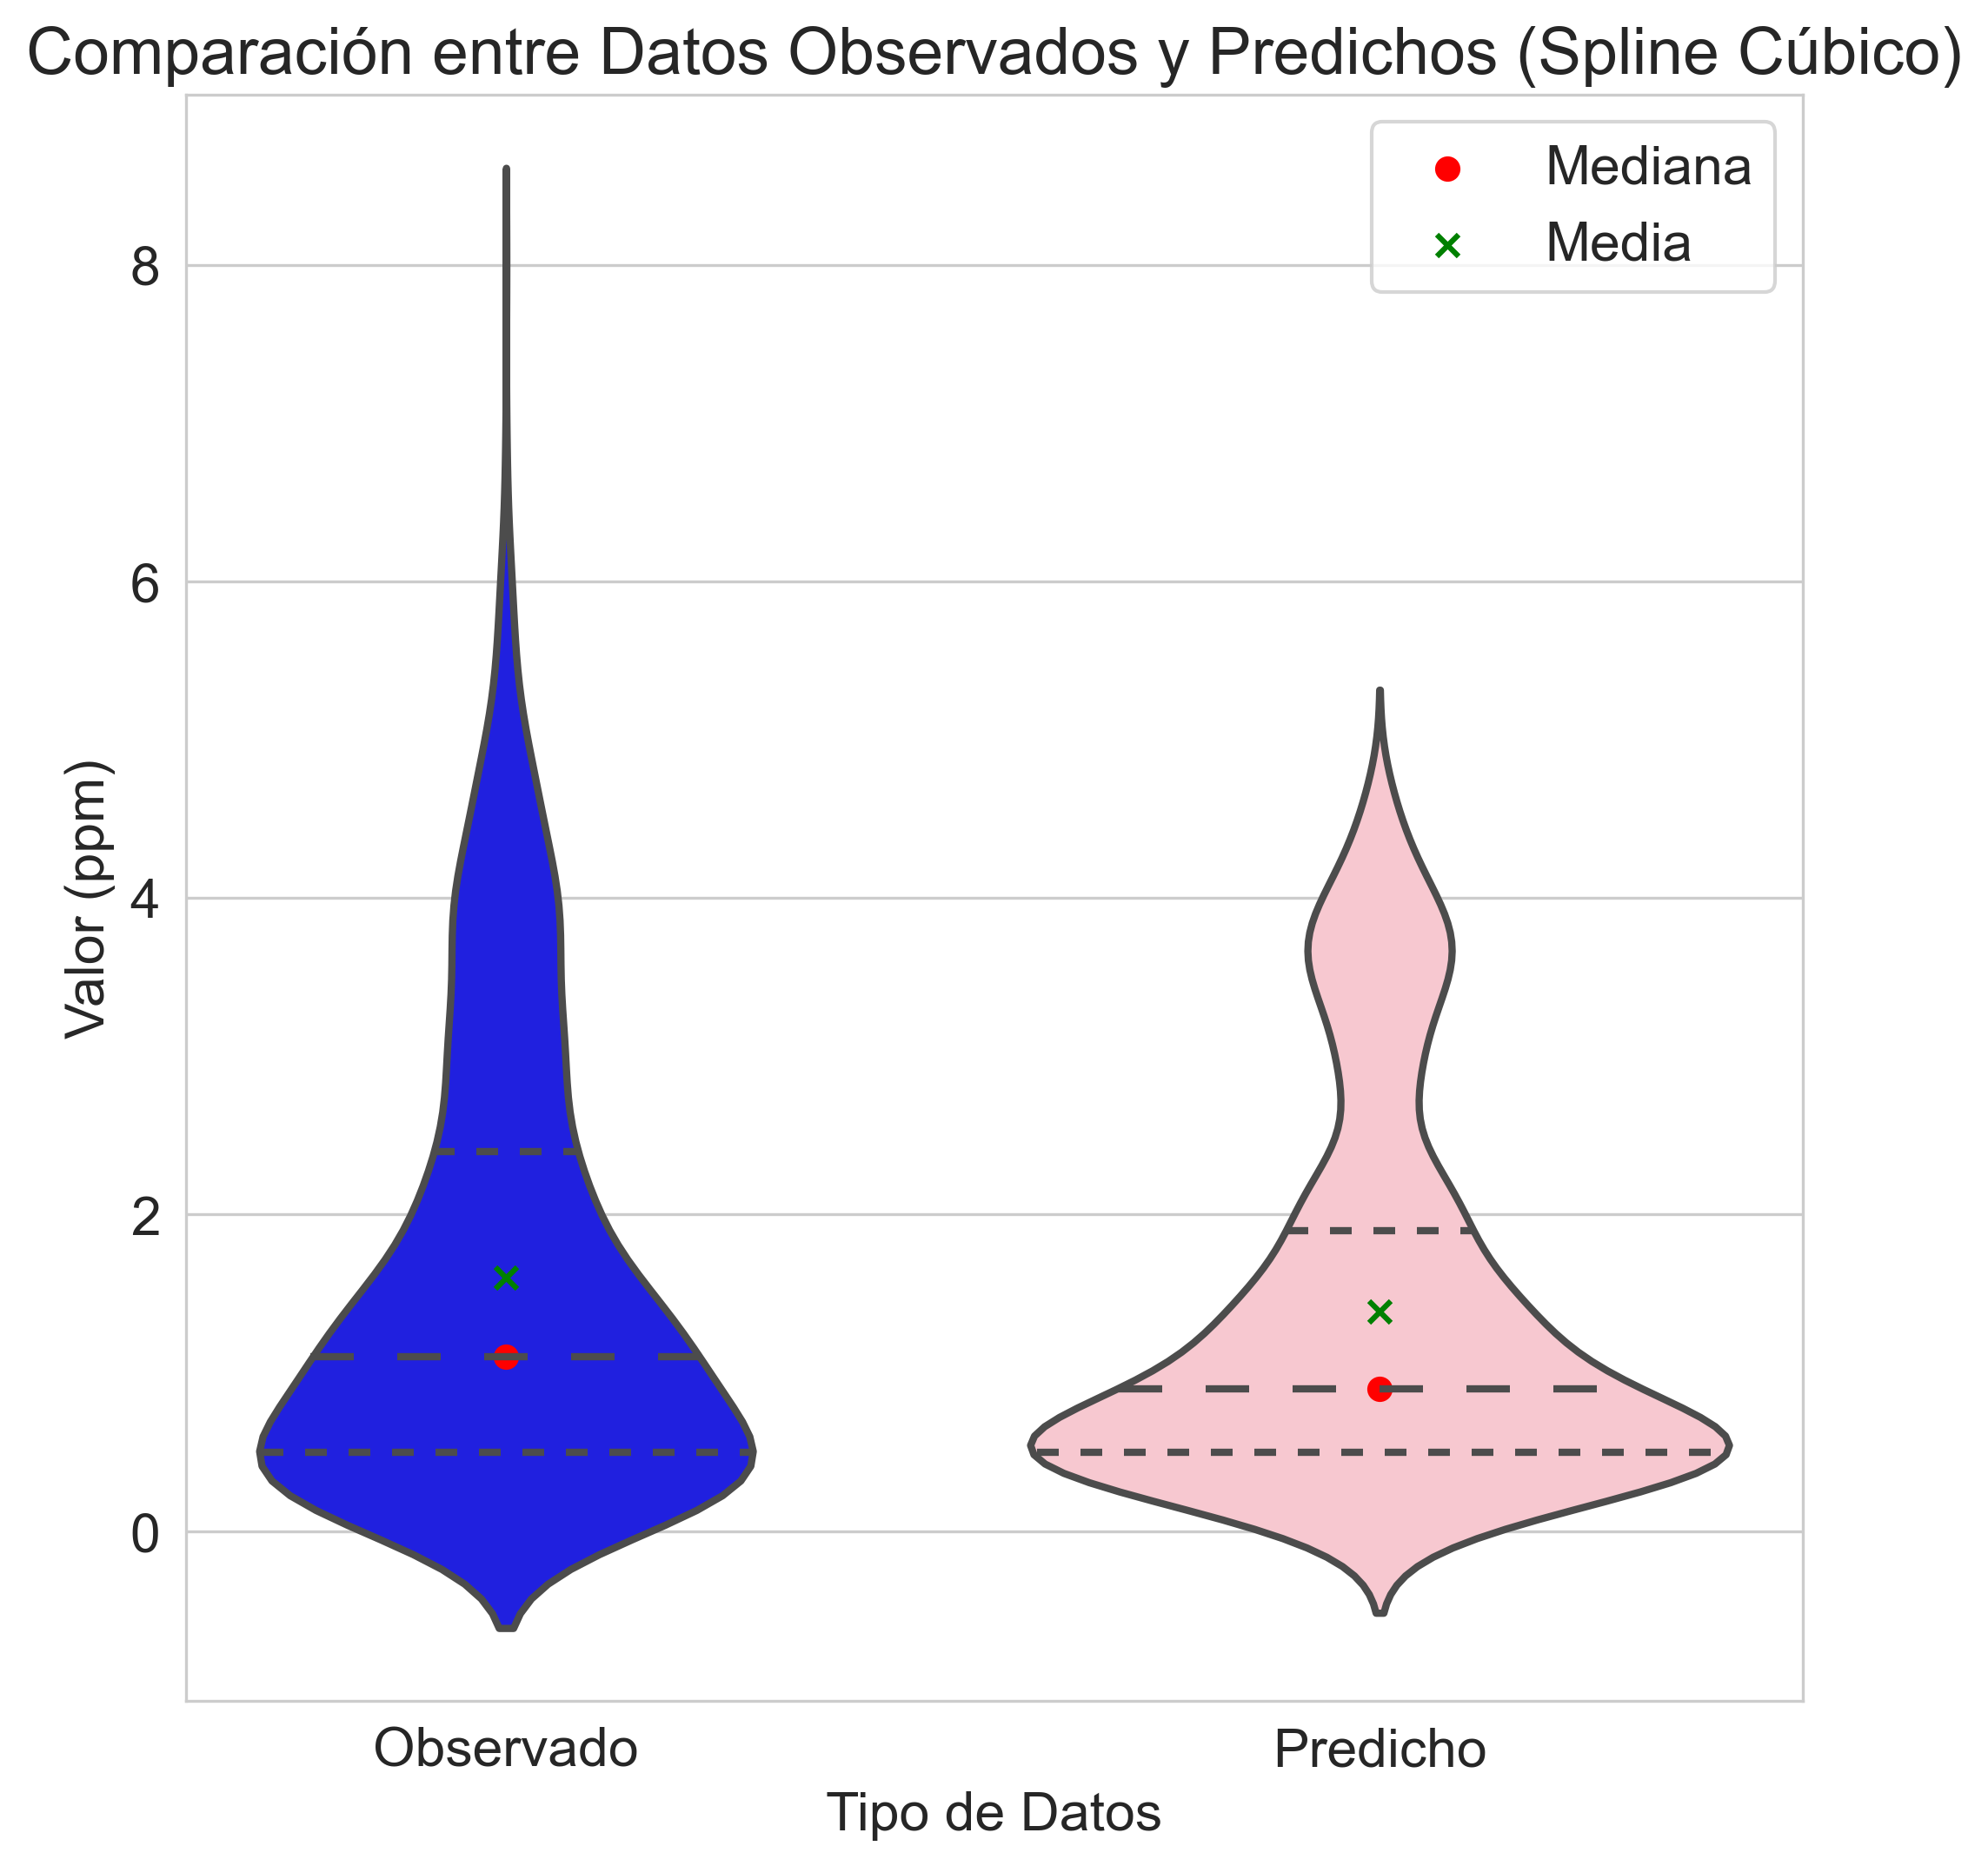

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8), dpi=300)
plt.rcParams.update({'font.size': 15, 'font.family': 'Garamond'})
sns.set_style("whitegrid")

sns.violinplot(data=[df_resultado1['obv'], df_resultado1['pre']], split=True,linewidth=2,linecolor="black",inner="quartile", palette=["blue", "pink"])
# Obtener estadísticas de interés
mediana_obv = df_resultado1['obv'].median()
mediana_pre = df_resultado1['pre'].median()

media_obv = df_resultado1['obv'].mean()
media_pre = df_resultado1['pre'].mean()

# Añadir marcadores para la mediana y la media
plt.scatter([0, 1], [mediana_obv, mediana_pre], color='red', marker='o', label='Mediana')
plt.scatter([0, 1], [media_obv, media_pre], color='green', marker='x', label='Media')

plt.title('Comparación entre Datos Observados y Predichos (Spline Cúbico)')

plt.xlabel('Tipo de Datos')
plt.ylabel('Valor (ppm)')
plt.legend()

plt.xticks(ticks=[0, 1], labels=['Observado', 'Predicho'])
plt.savefig('violin_plot_vsp.png', bbox_inches='tight', pad_inches=0.1)

# Mostrar el gráfico
plt.show()


<Figure size 6000x6000 with 0 Axes>

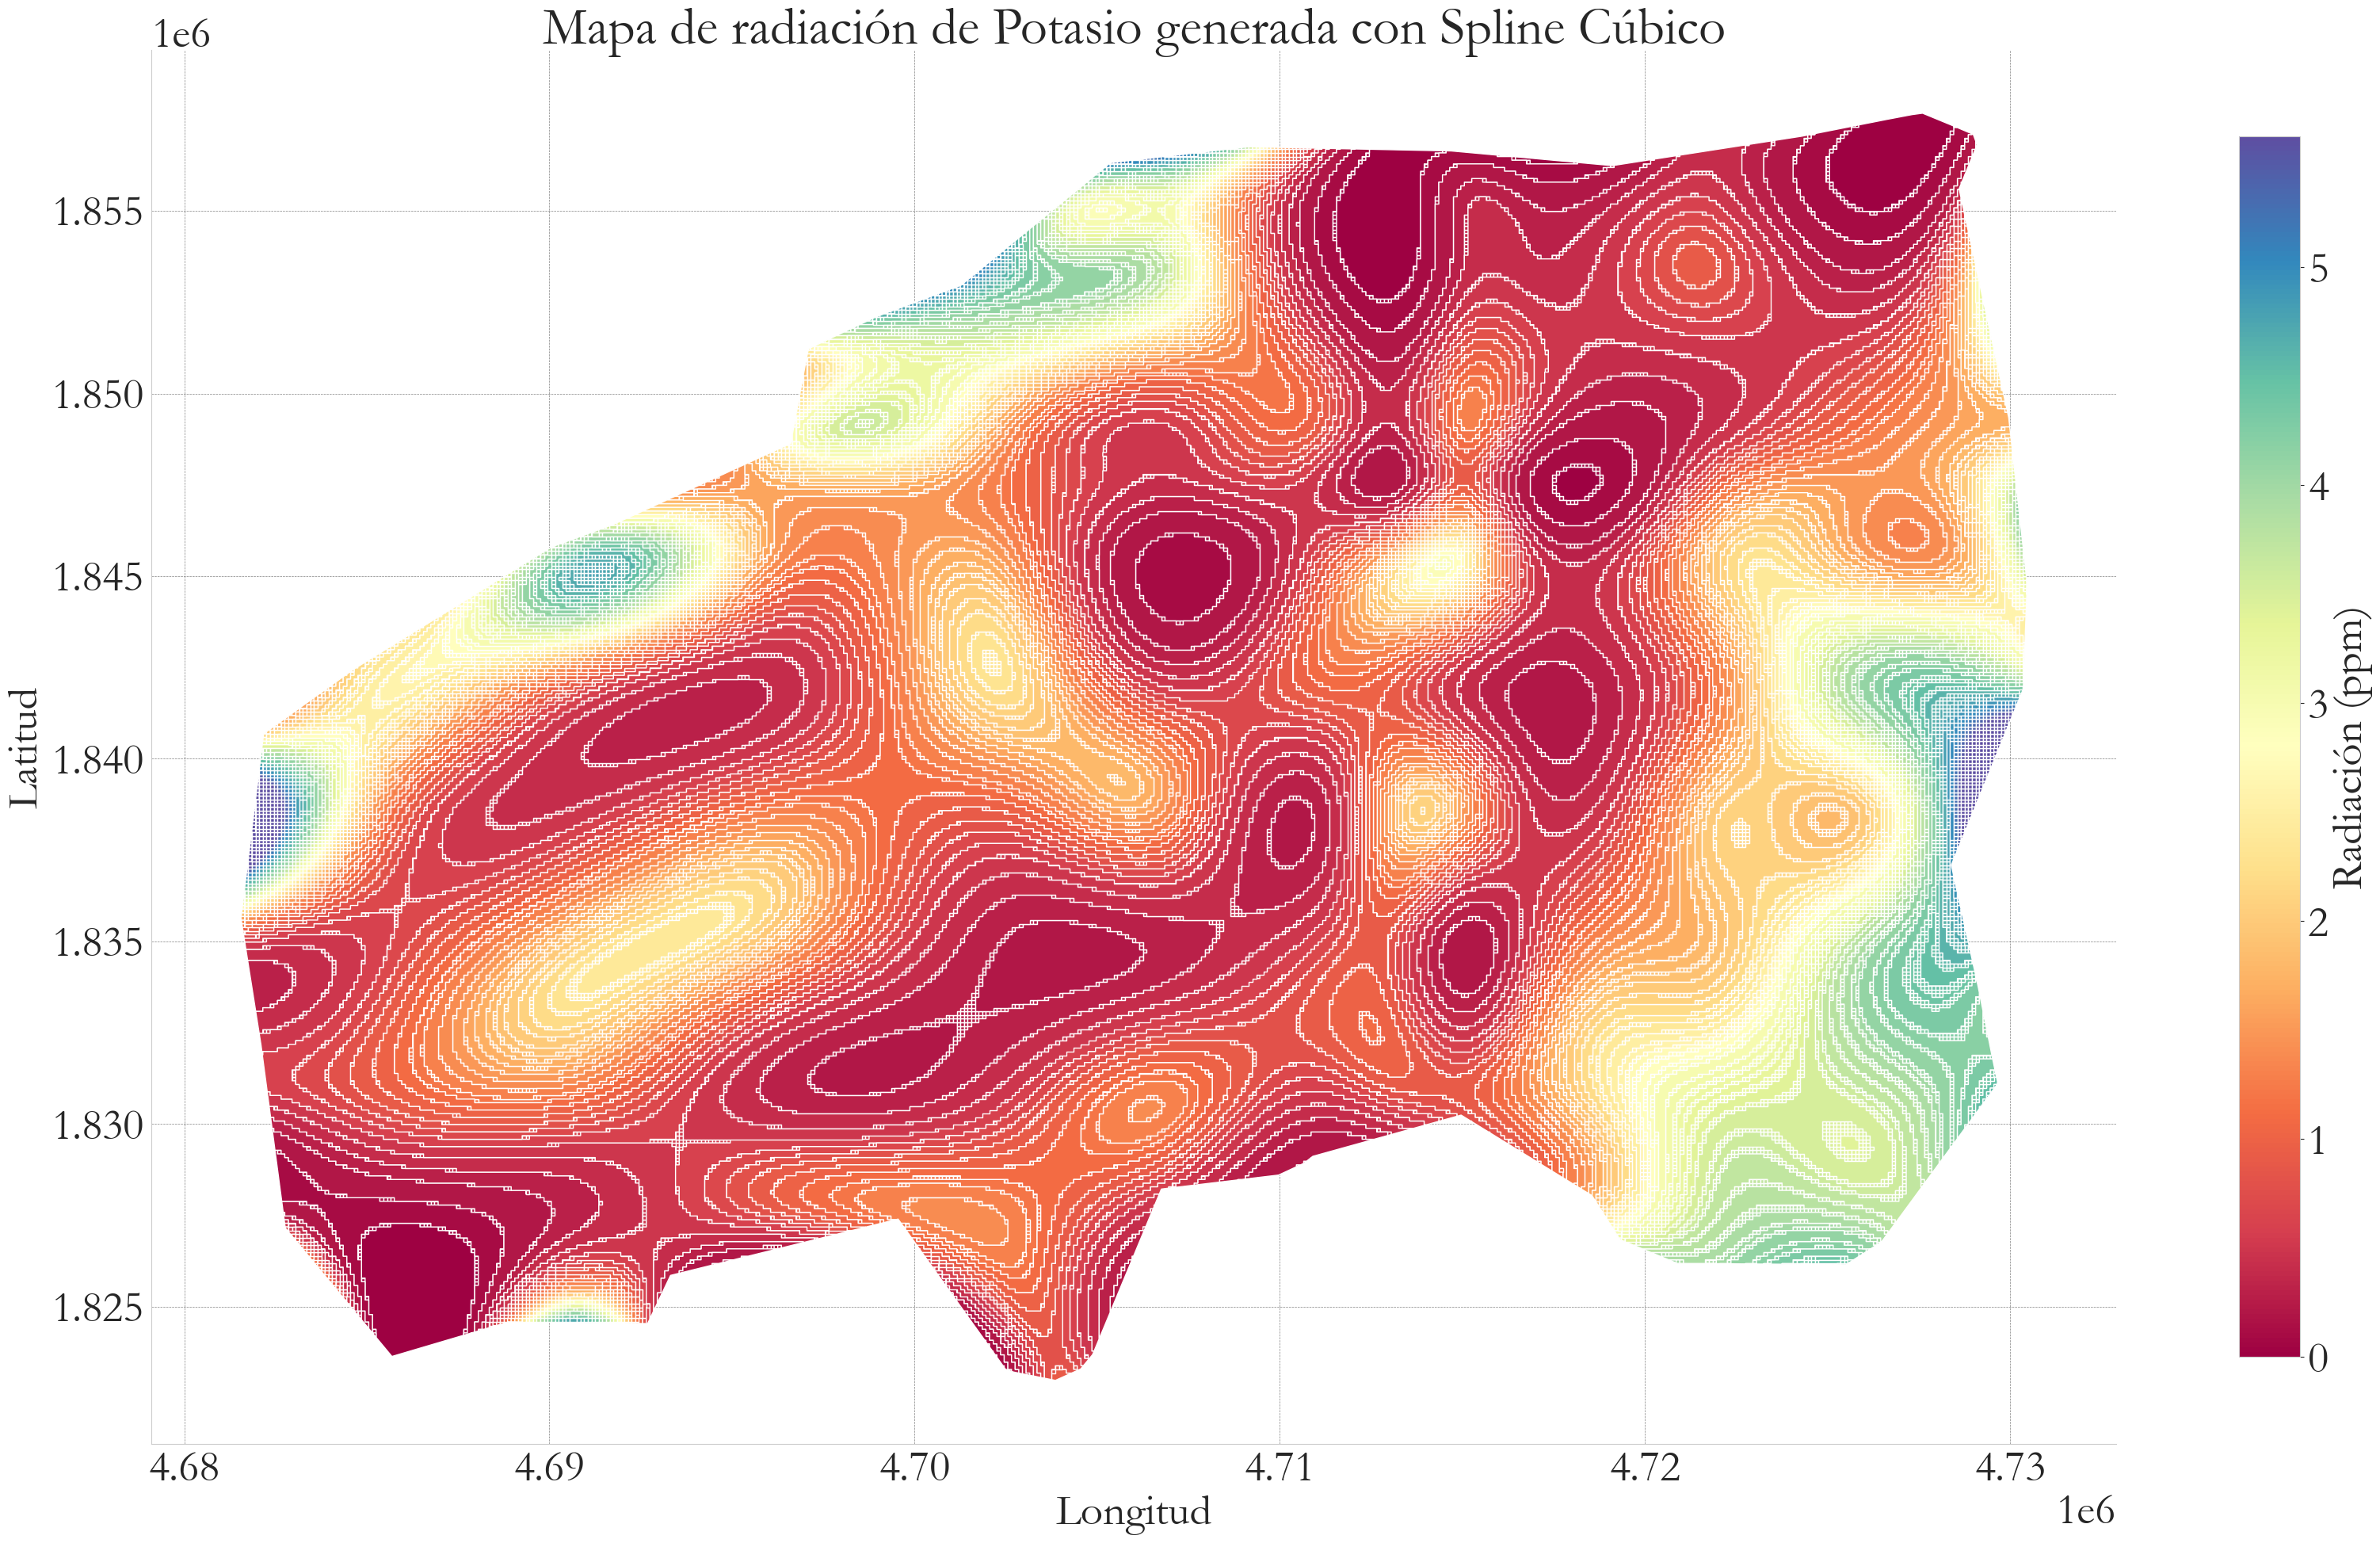

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20), dpi=300)
plt.rcParams.update({'font.size': 40, 'font.family': 'Garamond'})
plot = capa_vectorial_cortadat1.plot(column='valor_pixel', legend=False, figsize=(40, 40), cmap='Spectral',vmax=5.6)
plt.title('Mapa de radiación de Potasio generada con Spline Cúbico')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(plot.get_children()[0], ax=plot, shrink=0.5,label='Radiación (ppm)')
plt.grid(lw=0.5, color="gray", linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('v_splc.png', bbox_inches='tight', pad_inches=0.1)
plt.show()